In [1]:
from datetime import datetime
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
original_df = pd.read_parquet('../data/bronze/water_consumption.parquet')
weather_2023 = pd.read_parquet('../data/bronze/weather_2023.parquet')
weather_2024 = pd.read_parquet('../data/bronze/weather_2024.parquet')
weather_2024_complementary = pd.read_parquet('../data/bronze/weather_2024_complementary.parquet')

This code efficiently handles faulty rows in a dataset where both pumps are off despite a positive `input_flow_rate`, which is an operational anomaly. By calculating the average `input_flow_rate` for different pump configurations (`pump_1` on, `pump_2` on, and both pumps on) by `day` and `hour`, and also computing global averages, the code provides a robust fallback mechanism. It merges these averages with the main DataFrame, filling in missing values with global averages, ensuring no row is left unaddressed. For each anomalous row, it calculates the absolute differences between the current `input_flow_rate` and the calculated averages. It then determines the appropriate pump configuration by finding the minimum difference and assigns `pump_1`, `pump_2`, or both pumps accordingly. This vectorized approach avoids loops, making it efficient and scalable for large datasets. This method ensures that the dataset reflects more accurate and operationally efficient states, correcting scenarios where both pumps are off while there is incoming water, thereby maintaining the integrity and reliability of the data.


This code addresses rows in a dataset where at least one pump is on but the `input_flow_rate` is zero, which indicates an operational anomaly. By calculating the average `input_flow_rate` for different pump configurations (`pump_1` on, `pump_2` on, and both pumps on) by `day` and `hour`, and also computing global averages, the code provides a robust fallback mechanism. These averages are merged with the main DataFrame, and any missing values are filled with global averages to ensure no row is left unaddressed. For each anomalous row, the code determines the appropriate `input_flow_rate` based on the pump configuration and the corresponding average values. Using vectorized operations, it efficiently assigns the correct `input_flow_rate` by comparing the pump status with the calculated averages. This method maintains data integrity and ensures the dataset accurately reflects operational states, preventing scenarios where pumps are running without any recorded input flow.


In [3]:
def set_up(input_df):
    df = input_df.copy()
    df = df.rename(columns={
            "DATA/HORA": "timestamp",
            "VAZÃO ENTRADA (L/S)": "input_flow_rate",
            "NÍVEL RESERVATÓRIO (%)": "reservoir_level_percentage",
            "PRESSÃO (mca)": "pressure",
            "GMB 1 (10 OFF/ 90 ON)": "pump_1",
            "GMB 2(10 OFF/ 90 ON)": "pump_2",
        }).replace({
        "pump_1": {10: 0, 90: 1},
        "pump_2": {10: 0, 90: 1}
    })
    
    return df

def create_date_columns(input_df):
    original_df = input_df.copy()
    original_df['year'] = original_df['timestamp'].dt.year
    original_df['month'] = original_df['timestamp'].dt.month
    original_df['day'] = original_df['timestamp'].dt.day
    original_df['day_of_week'] = original_df['timestamp'].dt.weekday
    original_df['week_of_year'] = original_df['timestamp'].dt.isocalendar().week
    original_df['hour'] = original_df['timestamp'].dt.hour
    original_df['minute'] = original_df['timestamp'].dt.minute
    return original_df

def fix_small_window_empty_reservoir(input_df):
    df = input_df.copy()

    # Add a new column to mark rows where reservoir level was imputed
    df['inputed_reservoir_level'] = 0

    # Identify blocks of consecutive zero reservoir levels
    zero_reservoir_levels = df[df['reservoir_level_percentage'] == 0.0].index
    consecutive_blocks = []
    i = 0

    while i < len(zero_reservoir_levels):
        block = [zero_reservoir_levels[i]]
        while (i + 1 < len(zero_reservoir_levels) and
            zero_reservoir_levels[i + 1] == zero_reservoir_levels[i] + 1):
            i += 1
            block.append(zero_reservoir_levels[i])
        consecutive_blocks.append(block)
        i += 1

    # Process each block
    for block in consecutive_blocks:
        block_size = len(block)
        prev_index = block[0] - 1
        next_index = block[-1] + 1
        if prev_index >= 0 and next_index < len(df):
            prev_level = df.at[prev_index, 'reservoir_level_percentage']
            next_level = df.at[next_index, 'reservoir_level_percentage']
            if prev_level > 0 and next_level > 0:
                if block_size == 1:
                    # Scenario 1: Single zero reservoir level
                    df.at[block[0], 'reservoir_level_percentage'] = (prev_level + next_level) / 2
                    df.at[block[0], 'inputed_reservoir_level'] = 1
                elif block_size in [2, 3]:
                    # Scenario 2: Two or three consecutive zero reservoir levels
                    change = (next_level - prev_level) / (block_size + 1)
                    for i, idx in enumerate(block):
                        df.at[idx, 'reservoir_level_percentage'] = round(prev_level + change * (i + 1), 2)
                        df.at[idx, 'inputed_reservoir_level'] = 1
                        
        return df


def fix_pumps_of_with_input_rate(input_df):
    df = input_df.copy()

    # Calculate averages
    pump_1_avg = df[(df.pump_1 == 1) & (df.pump_2 == 0) & (df.input_flow_rate > 0)].groupby(['day', 'hour'])['input_flow_rate'].mean().to_frame(name='pump_1_avg')
    pump_2_avg = df[(df.pump_1 == 0) & (df.pump_2 == 1) & (df.input_flow_rate > 0)].groupby(['day', 'hour'])['input_flow_rate'].mean().to_frame(name='pump_2_avg')
    both_pumps_avg = df[(df.pump_1 == 1) & (df.pump_2 == 1) & (df.input_flow_rate > 0)].groupby(['day', 'hour'])['input_flow_rate'].mean().to_frame(name='both_pumps_avg')

    # Calculate global averages
    global_pump_1_avg = df[(df.pump_1 == 1) & (df.pump_2 == 0) & (df.input_flow_rate > 0)]['input_flow_rate'].mean()
    global_pump_2_avg = df[(df.pump_1 == 0) & (df.pump_2 == 1) & (df.input_flow_rate > 0)]['input_flow_rate'].mean()
    global_both_pumps_avg = df[(df.pump_1 == 1) & (df.pump_2 == 1) & (df.input_flow_rate > 0)]['input_flow_rate'].mean()

    # Merge averages with the main DataFrame
    df = df.merge(pump_1_avg, on=['day', 'hour'], how='left')
    df = df.merge(pump_2_avg, on=['day', 'hour'], how='left')
    df = df.merge(both_pumps_avg, on=['day', 'hour'], how='left')

    # Fill NaN values with global averages
    df['pump_1_avg'] = df['pump_1_avg'].fillna(global_pump_1_avg)
    df['pump_2_avg'] = df['pump_2_avg'].fillna(global_pump_2_avg)
    df['both_pumps_avg'] = df['both_pumps_avg'].fillna(global_both_pumps_avg)

    # Initialize the new column to 0
    df['inputed_pump_status'] = 0

    # Find rows with both pumps off and input flow rate > 0
    anomalies = (df.pump_1 == 0) & (df.pump_2 == 0) & (df.input_flow_rate > 0)

    # Determine the appropriate pump configuration
    pump_1_differences = np.abs(df.loc[anomalies, 'input_flow_rate'] - df.loc[anomalies, 'pump_1_avg'])
    pump_2_differences = np.abs(df.loc[anomalies, 'input_flow_rate'] - df.loc[anomalies, 'pump_2_avg'])
    both_pumps_differences = np.abs(df.loc[anomalies, 'input_flow_rate'] - df.loc[anomalies, 'both_pumps_avg'])

    # Find the minimum differences
    min_differences = np.minimum(np.minimum(pump_1_differences, pump_2_differences), both_pumps_differences)

    # Use vectorized assignment based on the comparison of differences
    df.loc[anomalies, 'pump_1'] = (min_differences == pump_1_differences).astype(int)
    df.loc[anomalies, 'pump_2'] = (min_differences == pump_2_differences).astype(int)

    # Assign both pumps if the minimum difference corresponds to both pumps
    both_pumps_condition = (min_differences == both_pumps_differences)
    df.loc[anomalies & both_pumps_condition, 'pump_1'] = 1
    df.loc[anomalies & both_pumps_condition, 'pump_2'] = 1

    # Set the inputed_pump_status column to 1 for rows where pump status was imputed
    df.loc[anomalies, 'inputed_pump_status'] = 1

    # Drop the average columns as they are no longer needed
    df = df.drop(columns=['pump_1_avg', 'pump_2_avg', 'both_pumps_avg'])
    
    return df

def fix_pumps_on_no_input_rate(input_df):
    df = input_df.copy()

    # Calculate averages
    pump_1_avg = df[(df.pump_1 == 1) & (df.pump_2 == 0) & (df.input_flow_rate > 0)].groupby(['day', 'hour'])['input_flow_rate'].mean().to_frame(name='pump_1_avg')
    pump_2_avg = df[(df.pump_1 == 0) & (df.pump_2 == 1) & (df.input_flow_rate > 0)].groupby(['day', 'hour'])['input_flow_rate'].mean().to_frame(name='pump_2_avg')
    both_pumps_avg = df[(df.pump_1 == 1) & (df.pump_2 == 1) & (df.input_flow_rate > 0)].groupby(['day', 'hour'])['input_flow_rate'].mean().to_frame(name='both_pumps_avg')

    # Calculate global averages
    global_pump_1_avg = df[(df.pump_1 == 1) & (df.pump_2 == 0) & (df.input_flow_rate > 0)]['input_flow_rate'].mean()
    global_pump_2_avg = df[(df.pump_1 == 0) & (df.pump_2 == 1) & (df.input_flow_rate > 0)]['input_flow_rate'].mean()
    global_both_pumps_avg = df[(df.pump_1 == 1) & (df.pump_2 == 1) & (df.input_flow_rate > 0)]['input_flow_rate'].mean()

    # Merge averages with the main DataFrame
    df = df.merge(pump_1_avg, on=['day', 'hour'], how='left')
    df = df.merge(pump_2_avg, on=['day', 'hour'], how='left')
    df = df.merge(both_pumps_avg, on=['day', 'hour'], how='left')

    # Fill NaN values with global averages
    df['pump_1_avg'] = df['pump_1_avg'].fillna(global_pump_1_avg)
    df['pump_2_avg'] = df['pump_2_avg'].fillna(global_pump_2_avg)
    df['both_pumps_avg'] = df['both_pumps_avg'].fillna(global_both_pumps_avg)

    # Initialize the new column to 0
    df['inputed_input_flow_rate'] = 0

    # Find rows with at least one pump on and input flow rate == 0
    anomalies = ((df.pump_1 == 1) | (df.pump_2 == 1)) & (df.input_flow_rate == 0)

    # Determine the appropriate input flow rate based on pump status
    df.loc[anomalies & (df.pump_1 == 1) & (df.pump_2 == 0), 'input_flow_rate'] = df.loc[anomalies & (df.pump_1 == 1) & (df.pump_2 == 0), 'pump_1_avg'].round(2)
    df.loc[anomalies & (df.pump_1 == 0) & (df.pump_2 == 1), 'input_flow_rate'] = df.loc[anomalies & (df.pump_1 == 0) & (df.pump_2 == 1), 'pump_2_avg'].round(2)
    df.loc[anomalies & (df.pump_1 == 1) & (df.pump_2 == 1), 'input_flow_rate'] = df.loc[anomalies & (df.pump_1 == 1) & (df.pump_2 == 1), 'both_pumps_avg'].round(2)

    # Set the inputed_input_flow_rate column to 1 for rows where input_flow_rate was imputed
    df.loc[anomalies, 'inputed_input_flow_rate'] = 1

    # Drop the average columns as they are no longer needed
    df = df.drop(columns=['pump_1_avg', 'pump_2_avg', 'both_pumps_avg'])
    
    return df

def gradually_subtract_reservoir_level(input_df, start_index, end_index, uniform_low=0.005, uniform_high=0.008):
    df = input_df.copy()
    prev_level = df.at[start_index - 1, 'reservoir_level_percentage']
    for idx in range(start_index, end_index + 1):
        random_decrease = np.random.uniform(uniform_low, uniform_high)
        new_level = prev_level * (1 - random_decrease)
        df.at[idx, 'reservoir_level_percentage'] = new_level
        df.at[idx, 'inputed_reservoir_level'] = 1
        prev_level = new_level
        
    return df

def gradually_increase_reservoir_level(input_df, start_index, end_index, uniform_low=0.005, uniform_high=0.008):
    df = input_df.copy()
    prev_level = df.at[start_index - 1, 'reservoir_level_percentage']
    for idx in range(start_index, end_index + 1):
        random_increase = np.random.uniform(uniform_low, uniform_high)
        new_level = prev_level * (1 + random_increase)
        df.at[idx, 'reservoir_level_percentage'] = new_level
        df.at[idx, 'inputed_reservoir_level'] = 1
        prev_level = new_level
        
    return df

def fix_window_8937_10255(input_df):
    df = input_df.copy()
    df = gradually_subtract_reservoir_level(df, 8937, 8992, 0.005, 0.008)
    df = gradually_increase_reservoir_level(df, 8993, 9045, 0.005, 0.008)
    df = gradually_subtract_reservoir_level(df, 9046, 9087, 0.005, 0.008)
    df = gradually_increase_reservoir_level(df, 9088, 9101, 0.005, 0.008)
    df = gradually_subtract_reservoir_level(df, 9102, 9149, 0.005, 0.008)
    df = gradually_increase_reservoir_level(df, 9150, 9173, 0.005, 0.008)
    df = gradually_subtract_reservoir_level(df, 9174, 9239, 0.005, 0.008)
    df = gradually_increase_reservoir_level(df, 9240, 9322, 0.005, 0.008)
    df = gradually_subtract_reservoir_level(df, 9323, 9451, 0.005, 0.008)
    df = gradually_increase_reservoir_level(df, 9452, 9499, 0.005, 0.008)
    df = gradually_subtract_reservoir_level(df, 9500, 9573, 0.005, 0.008)
    df = gradually_increase_reservoir_level(df, 9574, 9605, 0.005, 0.008)
    df = gradually_subtract_reservoir_level(df, 9606, 9628, 0.005, 0.008)
    df = gradually_increase_reservoir_level(df, 9629, 9677, 0.005, 0.008)
    df = gradually_subtract_reservoir_level(df, 9678, 9758, 0.005, 0.008)
    df = gradually_increase_reservoir_level(df, 9759, 9881, 0.005, 0.008)
    df = gradually_subtract_reservoir_level(df, 9882, 9967, 0.005, 0.008)
    df = gradually_increase_reservoir_level(df, 9967, 10059, 0.005, 0.008)
    df = gradually_subtract_reservoir_level(df, 10060, 10255, 0.002, 0.005)
    return df

def fix_window_23858_24246(input_df):
    df = input_df.copy()
    start_index = 23858
    end_index = 23858 + 50

    prev_level = df.at[start_index - 1, 'reservoir_level_percentage']
    for idx in range(start_index, end_index + 1):
        df.at[idx, 'input_flow_rate'] = 75.04
        df.at[idx, 'pump_1'] = 1
        df.at[idx, 'pump_2'] = 1
        df.at[idx, 'inputed_pump_status'] = 1
        df.at[idx, 'inputed_input_flow_rate'] = 1
        random_increase = np.random.uniform(0.005, 0.008)
        new_level = prev_level * (1 + random_increase)
        df.at[idx, 'reservoir_level_percentage'] = new_level
        df.at[idx, 'inputed_reservoir_level'] = 1
        prev_level = new_level
        
    df = gradually_subtract_reservoir_level(df, 23909, 24246, 0.0005, 0.001)

    start_index = 24246 - 15
    end_index = 24246 

    prev_level = df.at[start_index - 1, 'reservoir_level_percentage']
    for idx in range(start_index, end_index + 1):
        df.at[idx, 'input_flow_rate'] = 61.03
        df.at[idx, 'pump_1'] = 0
        df.at[idx, 'pump_2'] = 1
        df.at[idx, 'inputed_pump_status'] = 1
        df.at[idx, 'inputed_input_flow_rate'] = 1
        random_increase = np.random.uniform(0.003, 0.006)
        new_level = prev_level * (1 + random_increase)
        df.at[idx, 'reservoir_level_percentage'] = new_level
        df.at[idx, 'inputed_reservoir_level'] = 1
        prev_level = new_level
        
    return df

def fix_window_41845_42346(input_df):
    df = input_df.copy()
    df.at[41845, 'reservoir_level_percentage'] = df.at[41845-1, 'reservoir_level_percentage']
    df.at[41846, 'reservoir_level_percentage'] = df.at[41845-1, 'reservoir_level_percentage']
    df.at[41847, 'reservoir_level_percentage'] = df.at[41845-1, 'reservoir_level_percentage']

    df = gradually_subtract_reservoir_level(df, 41848, 41858, 0.002, 0.005)
    df = gradually_subtract_reservoir_level(df, 41859, 41892, 0.005, 0.006)
    df = gradually_increase_reservoir_level(df, 41893, 41955, 0.005, 0.008)
    df = gradually_subtract_reservoir_level(df, 41956, 42034, 0.005, 0.008)
    df = gradually_increase_reservoir_level(df, 42035, 42127, 0.001, 0.004)
    df = gradually_subtract_reservoir_level(df, 42128, 42176, 0.005, 0.006)
    df = gradually_increase_reservoir_level(df, 42177, 42232, 0.001, 0.004)
    df = gradually_subtract_reservoir_level(df, 42233, 42283, 0.005, 0.006)
    df = gradually_increase_reservoir_level(df, 42284, 42313, 0.001, 0.004)
    df = gradually_subtract_reservoir_level(df, 42314, 42346, 0.015, 0.020)
    
    return df

def fix_window_86748_8673(input_df):
    df = input_df.copy()
    start_index = 86762
    end_index = 86763 

    for idx in range(start_index, end_index + 1):
        df.at[idx, 'reservoir_level_percentage'] = 0

    df = gradually_subtract_reservoir_level(df, 86748, 86763, 0.005, 0.006)
    
    return df

def fill_missing_pressure(input_df):
    df = input_df.copy()
    df.pressure = df.pressure.replace(0.0, np.nan)
    df.pressure = df.pressure.fillna(df.pressure.rolling(window=10, min_periods=1).mean())
    df.pressure = df.pressure.fillna(df.pressure.mean())
    df.pressure = df.pressure.round(2)
    
    return df

def create_necessary_columns(input_df):
    df = input_df.copy()
    df['reservoir_level_liters'] = df['reservoir_level_percentage'] * 1_000_000 / 100
    df['time_passed_seconds'] = df['timestamp'].diff().dt.total_seconds()
    df['total_liters_entered'] = df['input_flow_rate'] * df['time_passed_seconds']
    df['effective_liters_entered'] = df['reservoir_level_liters'].diff()
    df['total_liters_out'] = df['total_liters_entered'] - df['effective_liters_entered']
    df['output_flow_rate'] = df['total_liters_out'] / df['time_passed_seconds']
    df.loc[df['effective_liters_entered'] < 0, 'effective_liters_entered'] = 0
    df = df.drop(0)
    df = df[df['total_liters_entered'] >= df['effective_liters_entered']]
    df = df[df['output_flow_rate'] <= 150]
    df = df[df['input_flow_rate'] <= 85]
    
    return df

def fix_df(input_df):
    original_df = input_df.copy()
    original_df = set_up(original_df)
    original_df = create_date_columns(original_df)
    df = original_df.copy()
    df = fix_pumps_of_with_input_rate(df)
    df = fix_pumps_on_no_input_rate(df)
    df = fix_small_window_empty_reservoir(df)
    df = fix_window_8937_10255(df)
    df = fix_window_23858_24246(df)
    df = fix_window_41845_42346(df)
    df = fix_window_86748_8673(df)
    df = gradually_subtract_reservoir_level(df, 101191, 101293, 0.010, 0.015)
    df = fill_missing_pressure(df)
    df = create_necessary_columns(df)
    return df

In [4]:
COLUMN_MAPPING = {
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'total_precip_mm',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'station_pressure_mb',
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'max_pressure_last_hour_mb',
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'min_pressure_last_hour_mb',
    'RADIACAO GLOBAL (Kj/m²)': 'global_radiation_kj_m2',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'air_temp_c',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'dew_point_temp_c',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'max_temp_last_hour_c',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'min_temp_last_hour_c',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)': 'max_dew_point_last_hour_c',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)': 'min_dew_point_last_hour_c',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'max_humidity_last_hour_percentage',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'min_humidity_last_hour_percentage',
    'UMIDADE RELATIVA DO AR, HORARIA (%)': 'relative_humidity_percentage',
    'VENTO, DIREÇÃO HORARIA (gr) (° (gr))': 'wind_direction_deg',
    'VENTO, RAJADA MAXIMA (m/s)': 'max_wind_gust_m_s',
    'VENTO, VELOCIDADE HORARIA (m/s)': 'wind_speed_m_s'
}

def preprocess_weather_dataset(input_df):
    df = input_df.copy()
    df.drop(df.columns[-1], axis=1, inplace=True) 
    df['Hora UTC'] = df['Hora UTC'].apply(lambda x: datetime.strptime(x, '%H%M %Z')) 
    df['Data'] = pd.to_datetime(df['Data'], format='%Y/%m/%d')
    df['hour'] = df['Hora UTC'].dt.hour
    df['day'] = df['Data'].dt.day
    df['month'] = df['Data'].dt.month
    df['year'] = df['Data'].dt.year
    df.rename(columns=COLUMN_MAPPING, inplace=True)
    df.drop(columns=['Data', 'Hora UTC'], axis=1, inplace=True)
    
    df = df[[
        "hour", "day", "month", "year", "relative_humidity_percentage", 
        "max_temp_last_hour_c", "min_temp_last_hour_c", "air_temp_c", 
        "total_precip_mm"
    ]]

    return df

def create_weather_dataset(df23, df24):
    df23 = preprocess_weather_dataset(df23)
    df24 = preprocess_weather_dataset(df24)
    df_23_24_concat = pd.concat([df23, df24], axis=0)
    return df_23_24_concat

In [5]:
def fill_na_with_moving_average(input_df, window=10):
    df = input_df.copy()
    
    for column in df.columns:
        if df[column].isna().sum() > 0:
            df[column] = df[column].transform(lambda x: x.fillna(x.rolling(window, min_periods=1).mean()))
            df[column] = df[column].ffill()
            df[column] = df[column].bfill()
        
    return df

def create_combined_dataset(input_df, input_weather_df, input_weather_complementary_df):
    df = input_df.copy()
    weather_df = input_weather_df.copy()
    merged_df = df.merge(weather_df, on=['hour', 'day', 'year', 'month'], how='left')
    comp_data = preprocess_weather_dataset(input_weather_complementary_df)
    merged_df = merged_df.sort_values(by=['day', 'month', 'hour', 'year'])
    comp_data = comp_data.sort_values(by=['day', 'month', 'hour', 'year'])
    merged_df_indexed = merged_df.set_index(['day', 'month', 'hour', 'year'])
    comp_data_indexed = comp_data.set_index(['day', 'month', 'hour', 'year'])
    merged_df_indexed.update(comp_data_indexed)
    full_df = merged_df_indexed.reset_index()
    filled_df = fill_na_with_moving_average(full_df)
    filled_df.sort_values(by='timestamp', inplace=True)
    filled_df = filled_df[[
        "timestamp", "minute", "hour", "day_of_week", "week_of_year", "year",
        "input_flow_rate", "reservoir_level_percentage", "pressure", "output_flow_rate",
        "pump_1", "pump_2", "air_temp_c", "total_precip_mm", "relative_humidity_percentage",
    ]]
    filled_df['time_diff'] = filled_df['timestamp'].diff().dt.total_seconds()
    filled_df['pump_1_duration'] = filled_df['pump_1'] * filled_df['time_diff']
    filled_df['pump_2_duration'] = filled_df['pump_2'] * filled_df['time_diff']
    filled_df.drop(0)
    return filled_df

def create_hourly_df(input_df):
    combined_df = input_df.copy()

    # Set the timestamp column as the index
    combined_df.set_index('timestamp', inplace=True)

    # Perform the resampling and aggregation
    hourly_df = combined_df.resample('h').agg({
        'minute': 'first',
        'hour': 'first',
        'day_of_week': 'first',
        'week_of_year': 'first',
        'year': 'first',
        'input_flow_rate': ['first', 'last', 'mean'],
        'reservoir_level_percentage': ['first', 'last', 'mean'],
        'output_flow_rate': ['first', 'last', 'mean'],
        'pressure': ['first', 'last', 'mean'],
        'pump_1_duration': 'sum',
        'pump_2_duration': 'sum',
        'air_temp_c': 'first',
        'total_precip_mm': 'first',
        'relative_humidity_percentage': 'first'
    }).assign(
        input_flow_rate_diff=lambda df: df[('input_flow_rate', 'last')] - df[('input_flow_rate', 'first')],
        output_flow_rate_diff=lambda df: df[('output_flow_rate', 'last')] - df[('output_flow_rate', 'first')],
        reservoir_level_change=lambda df: df[('reservoir_level_percentage', 'last')] - df[('reservoir_level_percentage', 'first')],
        pressure_change=lambda df: df[('pressure', 'last')] - df[('pressure', 'first')],
        pump_1_active=lambda df: df[('pump_1_duration', 'sum')] > 0,
        pump_2_active=lambda df: df[('pump_2_duration', 'sum')] > 0
    )

    # Flatten the MultiIndex columns
    hourly_df.columns = ['_'.join(col).strip() for col in hourly_df.columns.values]
    hourly_df = hourly_df.rename(columns={
        "input_flow_rate_diff_": "input_flow_rate_diff",
        "output_flow_rate_diff_": "output_flow_rate_diff",
        "reservoir_level_change_": "reservoir_level_change",
        "pressure_change_": "pressure_change",
        "pump_1_active_": "pump_1_active",
        "pump_2_active_": "pump_2_active",
        "air_temp_c_first": "air_temp_c",
        "total_precip_mm_first": "total_precip_mm",
        "relative_humidity_percentage_first": "relative_humidity_percentage",
    }).drop(columns={'minute_first', 'hour_first', 'day_of_week_first', 'week_of_year_first', 'year_first'}).reset_index(drop=False)
    
    for index, row, in hourly_df.iterrows():
        if row.isnull().any():
            
            # Access previous and next indices
            prev_index = hourly_df.index.get_loc(index) - 1
            next_index = hourly_df.index.get_loc(index) + 1
            
            hourly_df.at[index, 'input_flow_rate_first'] = hourly_df.at[prev_index, 'input_flow_rate_last']
            hourly_df.at[index, 'input_flow_rate_last'] = hourly_df.at[next_index, 'input_flow_rate_first'] if not hourly_df.iloc[next_index].isnull().any() else hourly_df.at[index, 'input_flow_rate_first']
            hourly_df.at[index, 'input_flow_rate_mean'] = (hourly_df.at[index, 'input_flow_rate_first'] + hourly_df.at[index, 'input_flow_rate_last']) / 2
            
            hourly_df.at[index, 'reservoir_level_percentage_first'] = hourly_df.at[prev_index, 'reservoir_level_percentage_last']
            hourly_df.at[index, 'reservoir_level_percentage_last'] = hourly_df.at[next_index, 'reservoir_level_percentage_first'] if not hourly_df.iloc[next_index].isnull().any() else hourly_df.at[index, 'reservoir_level_percentage_first']
            hourly_df.at[index, 'reservoir_level_percentage_mean'] = (hourly_df.at[index, 'reservoir_level_percentage_first'] + hourly_df.at[index, 'reservoir_level_percentage_last']) / 2
            
            hourly_df.at[index, 'output_flow_rate_first'] = hourly_df.at[prev_index, 'output_flow_rate_last']
            hourly_df.at[index, 'output_flow_rate_last'] = hourly_df.at[next_index, 'output_flow_rate_first'] if not hourly_df.iloc[next_index].isnull().any() else hourly_df.at[index, 'output_flow_rate_first']
            hourly_df.at[index, 'output_flow_rate_mean'] = (hourly_df.at[index, 'output_flow_rate_first'] + hourly_df.at[index, 'output_flow_rate_last']) / 2
            
            hourly_df.at[index, 'pressure_first'] = hourly_df.at[prev_index, 'pressure_last']
            hourly_df.at[index, 'pressure_last'] = hourly_df.at[next_index, 'pressure_first'] if not hourly_df.iloc[next_index].isnull().any() else hourly_df.at[index, 'pressure_first']
            hourly_df.at[index, 'pressure_mean'] = (hourly_df.at[index, 'pressure_first'] + hourly_df.at[index, 'pressure_last']) / 2
            
            hourly_df.at[index, 'pump_1_duration_sum'] = hourly_df.at[prev_index, 'pump_1_duration_sum']
            hourly_df.at[index, 'pump_2_duration_sum'] = hourly_df.at[prev_index, 'pump_2_duration_sum']
            
            hourly_df.at[index, 'air_temp_c'] = hourly_df.iloc[prev_index-3: prev_index].air_temp_c.mean().round(2)
            hourly_df.at[index, 'total_precip_mm'] = hourly_df.iloc[prev_index-3: prev_index].total_precip_mm.mean().round(2)
            hourly_df.at[index, 'relative_humidity_percentage'] = hourly_df.iloc[prev_index-3: prev_index].relative_humidity_percentage.mean().round(2)
            
            hourly_df.at[index, 'input_flow_rate_diff'] = hourly_df.at[index, 'input_flow_rate_last'] - hourly_df.at[index, 'input_flow_rate_first']
            hourly_df.at[index, 'output_flow_rate_diff'] = hourly_df.at[index, 'output_flow_rate_last'] - hourly_df.at[index, 'output_flow_rate_first']
            hourly_df.at[index, 'reservoir_level_change'] = hourly_df.at[index, 'reservoir_level_percentage_last'] - hourly_df.at[index, 'reservoir_level_percentage_first']
            hourly_df.at[index, 'pressure_change'] = hourly_df.iloc[prev_index-10:prev_index].pressure_change.diff().mean()
            
            hourly_df.at[index, 'pump_1_active'] = hourly_df.at[prev_index, 'pump_1_active']
            hourly_df.at[index, 'pump_2_active'] = hourly_df.at[prev_index, 'pump_2_active']
            
    hourly_df['change_from_last_hour_output_flow_rate_mean'] = hourly_df.output_flow_rate_mean.diff()
    hourly_df.drop(0, inplace=True)
    
    hourly_df['year'] = hourly_df['timestamp'].dt.year
    hourly_df['month'] = hourly_df['timestamp'].dt.month
    hourly_df['day'] = hourly_df['timestamp'].dt.day
    hourly_df['day_of_week'] = hourly_df['timestamp'].dt.weekday
    hourly_df['week_of_year'] = hourly_df['timestamp'].dt.isocalendar().week
    hourly_df['hour'] = hourly_df['timestamp'].dt.hour    
    hourly_df = hourly_df[[
        "timestamp", "year", "month", "day", "day_of_week", "week_of_year", "hour",
        "input_flow_rate_first", "input_flow_rate_last", "input_flow_rate_mean",
        "reservoir_level_percentage_first", "reservoir_level_percentage_last", "reservoir_level_percentage_mean",
        "output_flow_rate_first", "output_flow_rate_last", "output_flow_rate_mean",
        "pressure_first", "pressure_last", "pressure_mean",
        "pump_1_duration_sum", "pump_2_duration_sum",
        "air_temp_c", "total_precip_mm", "relative_humidity_percentage",
        "input_flow_rate_diff", "output_flow_rate_diff", "reservoir_level_change", "pressure_change",
        "pump_1_active", "pump_2_active", "change_from_last_hour_output_flow_rate_mean"
    ]]
    
    return hourly_df

In [6]:
df = fix_df(original_df)
weather_df = create_weather_dataset(weather_2023, weather_2024)
combined_df = create_combined_dataset(df, weather_df, weather_2024_complementary)
hourly_df = create_hourly_df(combined_df)

<Axes: title={'center': 'output_flow_rate_mean diff'}>

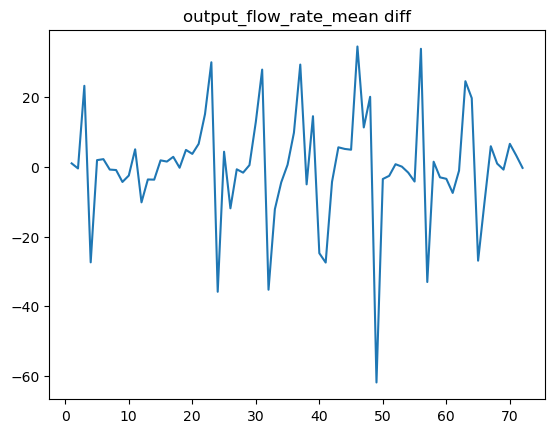

In [7]:
hourly_df.head(72).change_from_last_hour_output_flow_rate_mean.plot(title='output_flow_rate_mean diff')

In [10]:
hourly_df.head()

,timestamp,year,month,day,day_of_week,week_of_year,hour,input_flow_rate_first,input_flow_rate_last,input_flow_rate_mean,reservoir_level_percentage_first,reservoir_level_percentage_last,reservoir_level_percentage_mean,output_flow_rate_first,output_flow_rate_last,output_flow_rate_mean,pressure_first,pressure_last,pressure_mean,pump_1_duration_sum,pump_2_duration_sum,air_temp_c,total_precip_mm,relative_humidity_percentage,input_flow_rate_diff,output_flow_rate_diff,reservoir_level_change,pressure_change,pump_1_active,pump_2_active,change_from_last_hour_output_flow_rate_mean
1,2023-03-17 13:00:00,2023,3,17,4,11,13,65.64,65.24,65.587143,39.00,44.40,41.617143,45.640000,49.240000,50.704846,38.13,38.27,38.181429,0.0,3682.0,28.9,0.0,59.0,-0.40,3.600000,5.40,0.14,False,True,1.014115
2,2023-03-17 14:00:00,2023,3,17,4,11,14,66.46,65.64,65.654000,44.40,49.86,46.736500,66.460000,14.858750,50.261628,38.40,38.63,38.459000,0.0,3532.0,29.9,0.0,54.0,-0.82,-51.601250,5.46,0.23,False,True,-0.443218
3,2023-03-17 15:00:00,2023,3,17,4,11,15,65.64,33.74,49.395000,50.56,53.80,52.405000,42.306667,93.740000,73.561667,38.70,38.40,38.515000,150.0,3704.0,30.4,0.0,53.0,-31.90,51.433333,3.24,-0.30,True,True,23.300038
4,2023-03-17 16:00:00,2023,3,17,4,11,16,37.92,0.00,3.792000,53.80,38.76,45.368000,37.920000,56.000000,46.141631,38.50,31.12,32.054500,0.0,647.0,31.2,0.0,57.0,-37.92,18.080000,-15.04,-7.38,False,True,-27.420036
5,2023-03-17 17:00:00,2023,3,17,4,11,17,0.00,0.00,0.000000,37.90,21.20,29.540870,57.333333,66.666667,48.086957,31.05,30.25,30.594783,0.0,0.0,31.3,0.0,60.0,0.00,9.333333,-16.70,-0.80,False,False,1.945325
